In [1]:
%cd /content/drive/MyDrive/python_Training/OpenCV/
!unzip -qq '/content/drive/MyDrive/python_Training/OpenCV/archive.zip'

/content/drive/MyDrive/python_Training/OpenCV


파라미터 설정

In [2]:
batch_size = 32

In [3]:
import tensorflow as tf
img_g = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [32]:
train_dataset = img_g.flow_from_directory(directory = '/content/drive/MyDrive/python_Training/OpenCV/pokemon_jpg/',
                                          target_size = (64, 64),
                                          class_mode = 'categorical',
                                          subset = "training",
                                          batch_size = batch_size)

Found 656 images belonging to 1 classes.


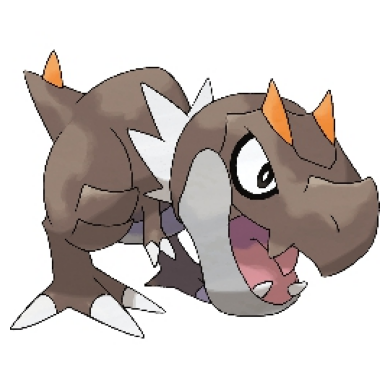

In [13]:
import matplotlib.pyplot as plt
for x, y in train_dataset:
    plt.imshow(x[0])
    plt.axis('off')
    plt.show()
    break

In [35]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# 생성자 모델 정의
def build_generator(input_shape):
    model = tf.keras.Sequential()
    model.add(Dense(64 * 16 * 16, use_bias=False, input_shape=input_shape))
    model.add(Reshape((16, 16, 64)))
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# 판별자 모델 정의
def build_discriminator(input_shape):
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [38]:
# DCGAN 모델 생성 및 컴파일
input_shape = (64, 64, 3)
generator = build_generator((100,))
discriminator = build_discriminator(input_shape)

discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy')

In [45]:
import numpy as np

def train_dcg(m, data, b_size, c_size, ec):
    gn_m = m.layers[0]  # 모델의 첫 번째 레이어는 생성자
    di_m = m.layers[1]  # 모델의 두 번째 레이어는 판별자

    for i in range(ec):
        print(f'{i + 1}/{ec}회')
        for x in data:
            # 1. 판별자 학습
            noise = tf.random.normal([b_size, c_size])  # z
            g_img = gn_m(noise)
            f_t_x = tf.concat([g_img, x], axis=0)
            y1 = np.array([[0.]] * b_size + [[1.]] * b_size, dtype=tf.float32)
            di_m.train_on_batch(f_t_x, y1)
            # 2. 생성자 학습
            noise = tf.random.normal([b_size, c_size])  # z
            y2 = np.array([[1.]] * b_size)
            m.train_on_batch(noise, y2)

        noise = tf.random.normal([10, 100])
        generated_images = gn_m(noise)
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # 이미지를 [0, 1] 범위로 변환
            plt.axis('off')
        plt.show()

train_dcg(gan, train_dataset, 32, 100, 10)

1/10회


ValueError: ignored

In [ ]:
# 생성된 이미지 시각화
noise = tf.random.normal([10, 100])
generated_images = generator(noise)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # 이미지를 [0, 1] 범위로 변환
    plt.axis('off')
plt.show()